# **Important Libraries**

In [ ]:
!pip install torchinfo segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import pandas as pd
import cv2
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split
import tifffile as tiff
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision import transforms, models
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# **Prepare Dataset**

In [ ]:
# Parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
NUM_CHANNELS = 12
BATCH_SIZE = 16
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
img_dir = "/content/drive/MyDrive/data/images"
mask_dir = "/content/drive/MyDrive/data/labels"

In [ ]:
len(os.listdir(img_dir)),len(os.listdir(mask_dir))

(306, 456)

In [ ]:
# Collect images and masks
images = [os.path.join(img_dir,file) for file in os.listdir(img_dir) if file.endswith('.tif')]
masks = [os.path.join(mask_dir,file) for file in os.listdir(mask_dir) if file.endswith('.png')]

# Create dictionaries to match images with masks
image_names = {os.path.splitext(os.path.basename(img))[0]: img for img in images}
mask_names = {os.path.splitext(os.path.basename(mask))[0]: mask for mask in masks}

# Find common keys
common_keys = sorted(set(image_names) & set(mask_names))

# Ensure only matching images and masks are used
images = [image_names[key] for key in common_keys]
masks = [mask_names[key] for key in common_keys]

print(f"Found {len(images)} matching image-mask pairs.")

Found 306 matching image-mask pairs.


In [ ]:
# Create DataFrame
df = pd.DataFrame({"images": images, "masks": masks})
df.head()

,images,masks
0,/content/drive/MyDrive/data/images/0.tif,/content/drive/MyDrive/data/labels/0.png
1,/content/drive/MyDrive/data/images/1.tif,/content/drive/MyDrive/data/labels/1.png
2,/content/drive/MyDrive/data/images/10.tif,/content/drive/MyDrive/data/labels/10.png
3,/content/drive/MyDrive/data/images/100.tif,/content/drive/MyDrive/data/labels/100.png
4,/content/drive/MyDrive/data/images/101.tif,/content/drive/MyDrive/data/labels/101.png


Sample image shape: (128, 128, 12)
Sample image shape: (128, 128, 12)
Sample image shape: (128, 128, 12)
Sample image shape: (128, 128, 12)
Sample image shape: (128, 128, 12)
Sample image shape: (128, 128, 12)


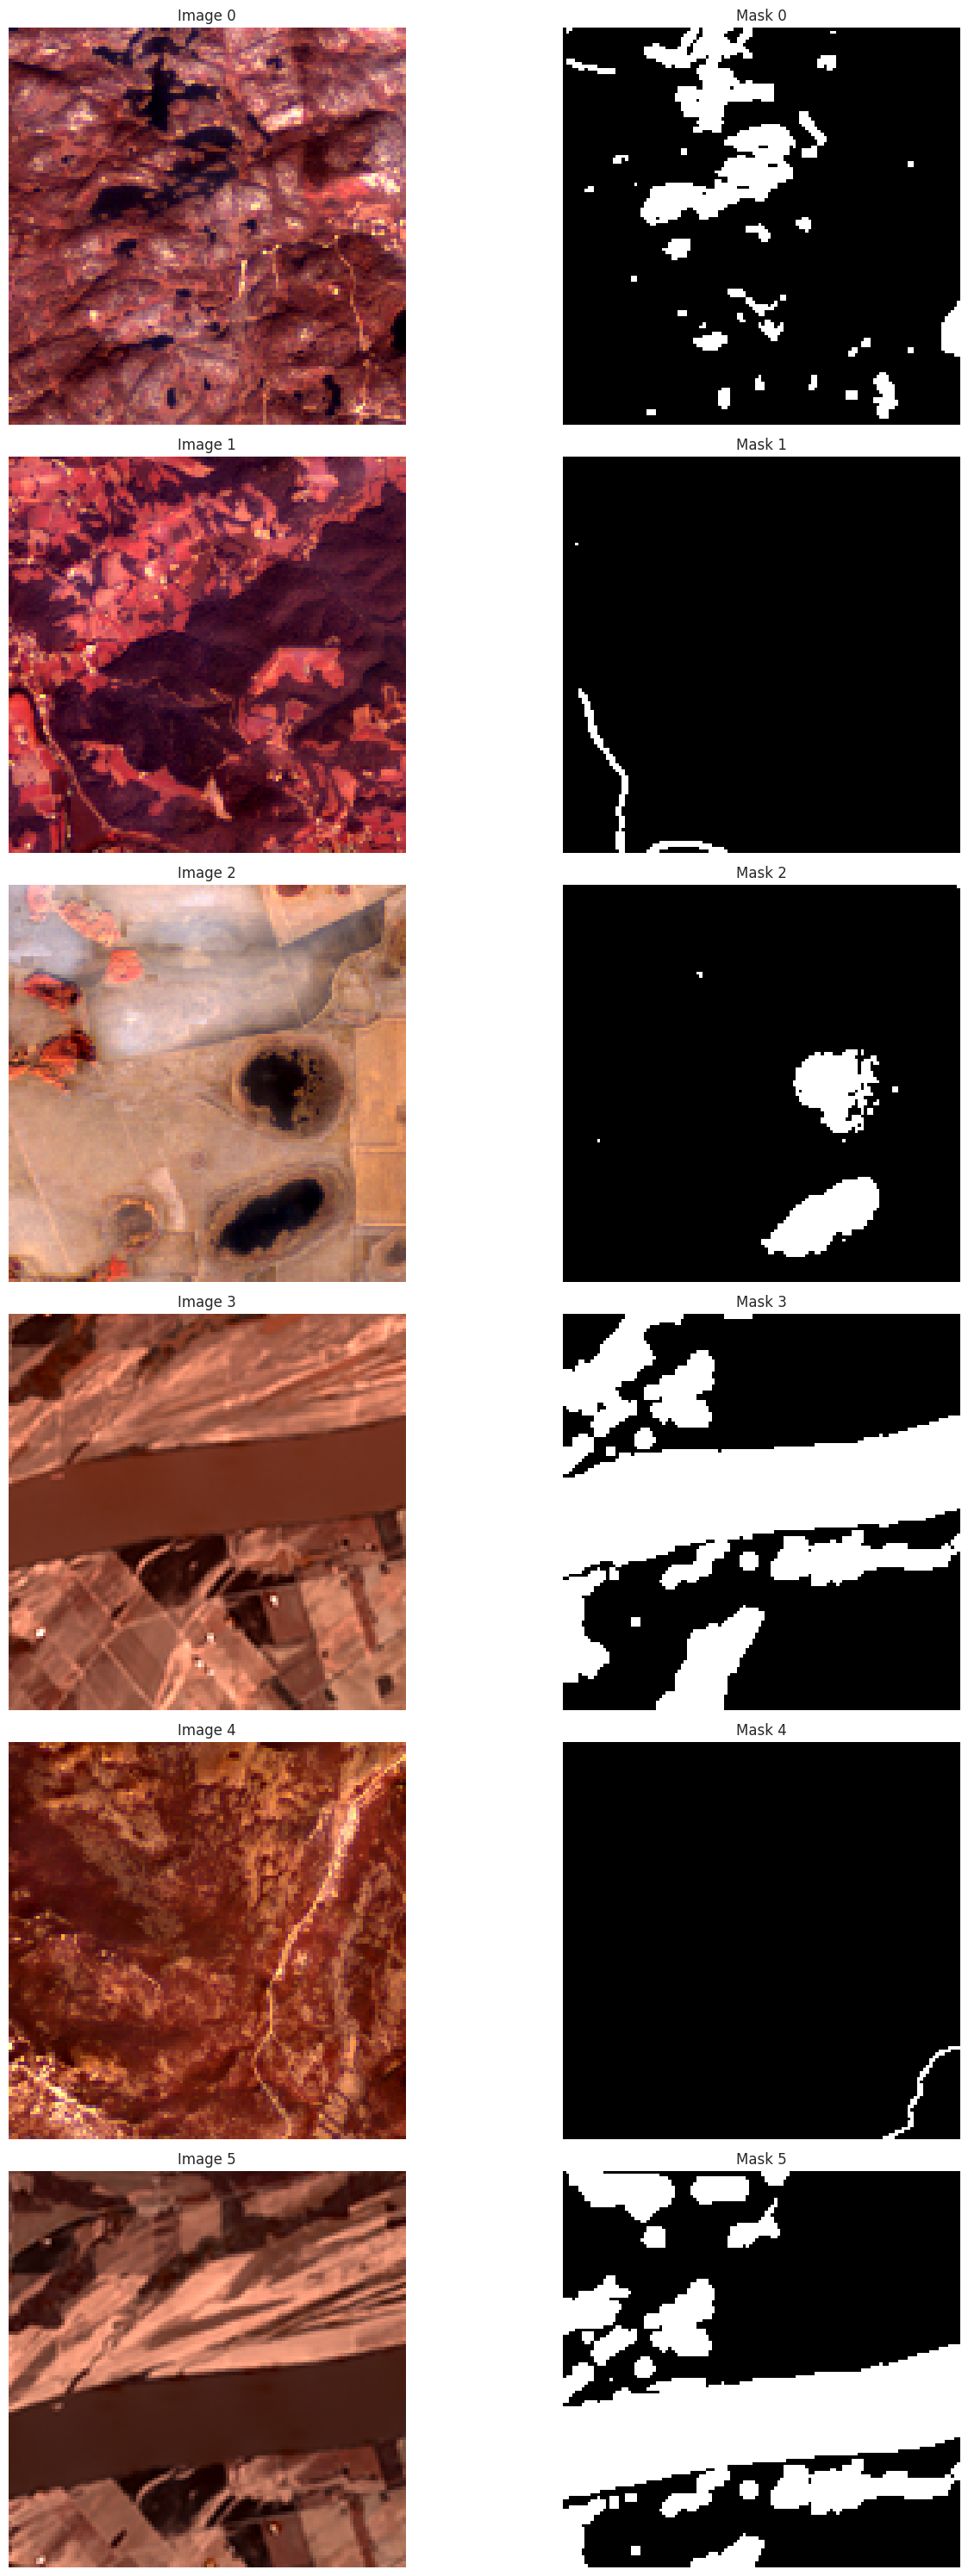

In [ ]:
# Visualization
def visualize_image_mask_pairs(df, num_samples=6):
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        # Load image and mask paths
        img_path = df['images'].iloc[i]
        mask_path = df['masks'].iloc[i]

        # Read full multi-channel image
        img_full = tiff.imread(img_path)
        print(f"Sample image shape: {img_full.shape}")

        # Read mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if len(img_full.shape) == 3 and img_full.shape[2] >= 3:
            img_rgb_vis = img_full[:, :, [2, 1, 0]]
            # Normalize for better display contrast
            pmin, pmax = np.percentile(img_rgb_vis, (0.5, 99.5))
            img_rgb_vis = np.clip(img_rgb_vis, pmin, pmax)
            img_rgb_vis = ((img_rgb_vis - pmin) / (pmax - pmin + 1e-8) * 255).astype(np.uint8)
        elif len(img_full.shape) == 2:
             img_rgb_vis = cv2.cvtColor(img_full, cv2.COLOR_GRAY2RGB)
        else:
             # Fallback if less than 3 channels
             print(f"Warning: Image {img_path} has {img_full.shape[-1]} channels, cannot create RGB.")
             img_rgb_vis = np.zeros((img_full.shape[0], img_full.shape[1], 3), dtype=np.uint8)


        # Ensure correct display size
        if img_rgb_vis.shape[0] != IMG_HEIGHT or img_rgb_vis.shape[1] != IMG_WIDTH:
            img_rgb_vis = cv2.resize(img_rgb_vis, (IMG_WIDTH, IMG_HEIGHT))
        if mask.shape[0] != IMG_HEIGHT or mask.shape[1] != IMG_WIDTH:
             mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)


        # Plot image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(img_rgb_vis)
        plt.title(f'Image {i}')
        plt.axis('off')

        # Plot mask
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Mask {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize to check
visualize_image_mask_pairs(df)

In [ ]:
# Split the dataset
def split_df(df):
    train_df, dummy_df = train_test_split(df, train_size=0.8, random_state=42)
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, random_state=42)
    return train_df, valid_df, test_df

train_df, valid_df, test_df = split_df(df)
print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(valid_df)} samples")
print(f"Test set: {len(test_df)} samples")

Training set: 244 samples
Validation set: 31 samples
Test set: 31 samples


# **Create Custom Dataset**

In [ ]:
class WaterSegmentationDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)


  def __getitem__(self, idx):
    imgpath = self.df['images'].iloc[idx]
    maskpath = self.df['masks'].iloc[idx]

    # Load image
    image = tiff.imread(imgpath)
    if image.shape[0] == NUM_CHANNELS:
      image = image.transpose((1,2,0))

    # Load mask
    mask = cv2.imread(maskpath, cv2.IMREAD_GRAYSCALE)
    mask = (mask > 0).astype(np.uint8) # Binary mask

    # Apply transformations
    if self.transform:
      transforms = self.transform(image=image,mask=mask)
      image = transforms['image']
      mask = transforms['mask']
    return image, mask

In [ ]:
# Data Augmentation
train_transform = A.Compose([
    A.Resize(IMG_HEIGHT, IMG_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=[0.5] * NUM_CHANNELS, std=[0.5] * NUM_CHANNELS),
    ToTensorV2(),
])

valid_transform = A.Compose([
    A.Resize(IMG_HEIGHT, IMG_WIDTH),
    A.Normalize(mean=[0.5] * NUM_CHANNELS, std=[0.5] * NUM_CHANNELS),
    ToTensorV2(),
])

In [ ]:
train_dataset = WaterSegmentationDataset(df = train_df, transform=train_transform)
valid_dataset = WaterSegmentationDataset(df = valid_df, transform=valid_transform)
test_dataset = WaterSegmentationDataset(df = test_df, transform=valid_transform)

In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# **Model & Evaluation**

In [ ]:
# Define metrics
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    union = y_true_f.sum() + y_pred_f.sum() - intersection
    return (intersection + smooth) / (union + smooth)

In [ ]:
# Initialize UNet++ model
model = smp.UnetPlusPlus(
    encoder_name='efficientnet-b3',
    encoder_weights='imagenet',
    in_channels=NUM_CHANNELS,
    classes=1
).to(DEVICE)

summary(model, input_size=(1, 12, 128, 128))

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Layer (type:depth-idx)                                  Output Shape              Param #
UnetPlusPlus                                            [1, 1, 128, 128]          --
├─EfficientNetEncoder: 1-1                              [1, 12, 128, 128]         592,896
│    └─Conv2dStaticSamePadding: 2-1                     [1, 40, 64, 64]           4,320
│    │    └─ZeroPad2d: 3-1                              [1, 12, 129, 129]         --
│    └─BatchNorm2d: 2-2                                 [1, 40, 64, 64]           80
│    └─SiLU: 2-3                                        [1, 40, 64, 64]           --
│    └─ModuleList: 2-4                                  --                        --
│    │    └─MBConvBlock: 3-2                            [1, 24, 64, 64]           2,298
│    │    └─MBConvBlock: 3-3                            [1, 24, 64, 64]           1,206
│    │    └─MBConvBlock: 3-4                            [1, 32, 32, 32]           11,878
│    │    └─MBConvBlock: 3-5              

In [ ]:
# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.001)

In [ ]:
# Training loop
def train_model(model, train_loader, valid_loader, num_epochs=60):
    best_dice = 0.0
    history = {'train_loss': [], 'train_dice': [], 'train_iou': [],
               'valid_loss': [], 'valid_dice': [], 'valid_iou': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_dice, train_iou = 0.0, 0.0, 0.0
        for images, masks in train_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()

            # Calculate metrics
            preds = torch.sigmoid(outputs) > 0.5
            train_loss += loss.item() * images.size(0)
            train_dice += dice_coef(masks, preds).item() * images.size(0)
            train_iou += iou_coef(masks, preds).item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_dice /= len(train_loader.dataset)
        train_iou /= len(train_loader.dataset)

        # Validation
        model.eval()
        valid_loss, valid_dice, valid_iou = 0.0, 0.0, 0.0
        with torch.no_grad():
            for images, masks in valid_loader:
                images, masks = images.to(DEVICE), masks.to(DEVICE).float().unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, masks)

                preds = torch.sigmoid(outputs) > 0.5
                valid_loss += loss.item() * images.size(0)
                valid_dice += dice_coef(masks, preds).item() * images.size(0)
                valid_iou += iou_coef(masks, preds).item() * images.size(0)

        valid_loss /= len(valid_loader.dataset)
        valid_dice /= len(valid_loader.dataset)
        valid_iou /= len(valid_loader.dataset)

        # Save best model
        if valid_dice > best_dice:
            best_dice = valid_dice
            torch.save(model.state_dict(), 'unetplusplus_best.pth')

        # Log metrics
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['valid_loss'].append(valid_loss)
        history['valid_dice'].append(valid_dice)
        history['valid_iou'].append(valid_iou)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}')
        print(f'Valid Loss: {valid_loss:.4f}, Dice: {valid_dice:.4f}, IoU: {valid_iou:.4f}')
        print('-' * 50)

    return history

# Train the model
history = train_model(model, train_loader, valid_loader)

Epoch 1/60
Train Loss: 0.4172, Dice: 0.6823, IoU: 0.5331
Valid Loss: 4.4935, Dice: 0.3292, IoU: 0.1975
--------------------------------------------------
Epoch 2/60
Train Loss: 0.2939, Dice: 0.7807, IoU: 0.6470
Valid Loss: 1.0744, Dice: 0.4866, IoU: 0.3236
--------------------------------------------------
Epoch 3/60
Train Loss: 0.3162, Dice: 0.7470, IoU: 0.6025
Valid Loss: 0.5978, Dice: 0.6228, IoU: 0.4546
--------------------------------------------------
Epoch 4/60
Train Loss: 0.2520, Dice: 0.8103, IoU: 0.6842
Valid Loss: 0.3506, Dice: 0.7041, IoU: 0.5445
--------------------------------------------------
Epoch 5/60
Train Loss: 0.2461, Dice: 0.7987, IoU: 0.6681
Valid Loss: 0.2548, Dice: 0.7451, IoU: 0.5950
--------------------------------------------------
Epoch 6/60
Train Loss: 0.2381, Dice: 0.8119, IoU: 0.6877
Valid Loss: 0.2259, Dice: 0.7615, IoU: 0.6157
--------------------------------------------------
Epoch 7/60
Train Loss: 0.2102, Dice: 0.8431, IoU: 0.7309
Valid Loss: 0.2016,

In [ ]:
# Evaluation function
def evaluate_model(model, loader):
    model.eval()
    total_loss, total_dice, total_iou, total_acc = 0.0, 0.0, 0.0, 0.0
    total_samples = 0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, masks)

            preds = torch.sigmoid(outputs) > 0.5
            total_loss += loss.item() * images.size(0)
            total_dice += dice_coef(masks, preds).item() * images.size(0)
            total_iou += iou_coef(masks, preds).item() * images.size(0)
            total_acc += (preds == masks).float().mean().item() * images.size(0)
            total_samples += images.size(0)

    return (total_loss / total_samples, total_acc / total_samples,
            total_iou / total_samples, total_dice / total_samples)

In [ ]:
# Evaluate on train, validation, and test sets
train_score = evaluate_model(model, train_loader)
valid_score = evaluate_model(model, valid_loader)
test_score = evaluate_model(model, test_loader)

# Print results
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train IoU: ", train_score[2])
print("Train Dice: ", train_score[3])
print('-' * 20)

print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print("Valid IoU: ", valid_score[2])
print("Valid Dice: ", valid_score[3])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test IoU: ", test_score[2])
print("Test Dice: ", test_score[3])

Train Loss:  0.12032016000298203
Train Accuracy:  0.9509990254386527
Train IoU:  0.8191652122091074
Train Dice:  0.899219922354964
--------------------
Valid Loss:  0.11680762037154167
Valid Accuracy:  0.951839360498613
Valid IoU:  0.8207512901675317
Valid Dice:  0.9015354283394352
--------------------
Test Loss:  0.11223011271607491
Test Accuracy:  0.9535089519716078
Test IoU:  0.7898392696534434
Test Dice:  0.8825657367706299


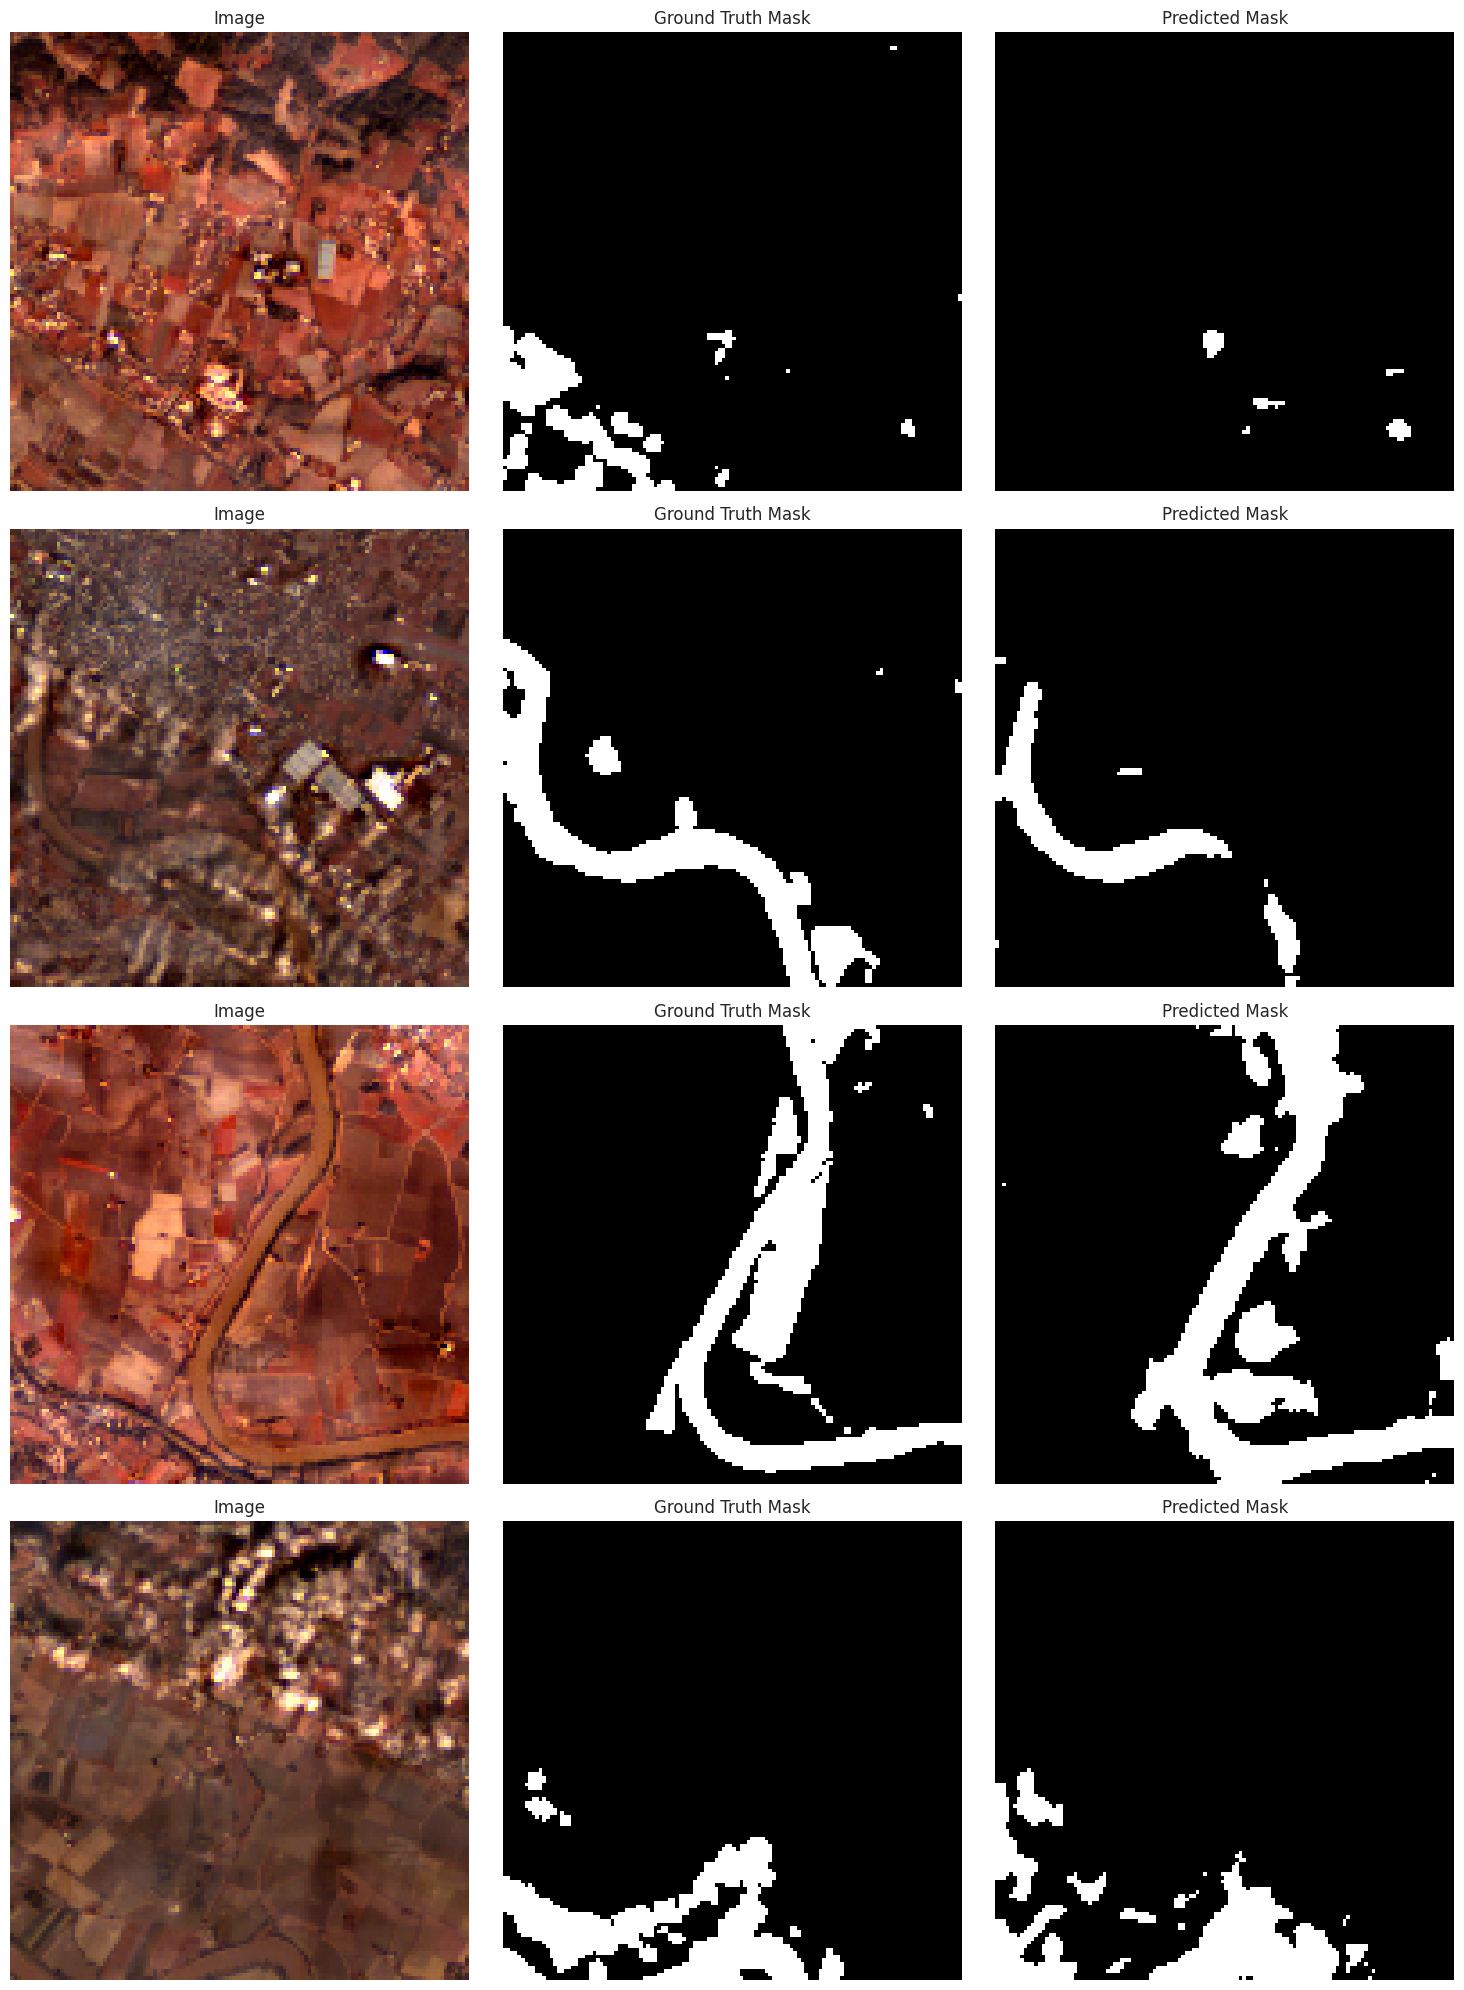

In [ ]:
def visualize_inference(model, test_loader, num_samples=4):
    model.eval()
    sample_count = 0
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    if num_samples == 1:
        axes = [axes]

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE).float().unsqueeze(1)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            for b in range(images.size(0)):
                if sample_count >= num_samples:
                    break

                img_np_full = images[b].cpu().numpy()  # (12, H, W)


                if img_np_full.shape[0] >= 3:
                    img_rgb_vis = img_np_full[[2, 1, 0], :, :].transpose(1, 2, 0)
                    pmin, pmax = np.percentile(img_rgb_vis, (0.5, 99.5))
                    img_rgb_vis = np.clip(img_rgb_vis, pmin, pmax)
                    img_rgb_vis = ((img_rgb_vis - pmin) / (pmax - pmin + 1e-8)).clip(0, 1)
                else:
                    img_rgb_vis = np.zeros((img_np_full.shape[1], img_np_full.shape[2], 3))

                mask_np = masks[b, 0].cpu().numpy()
                pred_np = preds[b, 0].cpu().numpy()

                axes[sample_count][0].imshow(img_rgb_vis)
                axes[sample_count][1].imshow(mask_np, cmap='gray')
                axes[sample_count][2].imshow(pred_np, cmap='gray')

                axes[sample_count][0].set_title('Image')
                axes[sample_count][1].set_title('Ground Truth Mask')
                axes[sample_count][2].set_title('Predicted Mask')

                for ax in axes[sample_count]:
                    ax.axis('off')

                sample_count += 1

            if sample_count >= num_samples:
                break

    plt.tight_layout()
    plt.show()


visualize_inference(model, test_loader)